In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Loading the Galileo E1 PRNs in hexadecimal format with a pandas dataframe
There exist two different kind of PRN codes for Galileo E1: E1B and E1C.
They are contained, in hexadecimal format, in the files called repectively "E1B - Gal.txt" and "E1C - Gal.txt"

First we start by considering the E1B PRNs:

In [2]:
filename = "E1B - Gal.txt"

# defining the name of the column of the dataframe called e1b
columns = ["Hexadecimal"]

#reading the file
e1b = pd.read_table(filename, sep='\n', header=None, names=columns)

# deleting the first 15 characters (not part of the code)
e1b['Hexadecimal'] = [el[16::] for el in e1b['Hexadecimal']]

# creating a new column with the codes indexes and placing it as first column
e1b['Code index'] = np.arange(1,51,1)
column_list = ["Code index", "Hexadecimal"]
e1b = e1b.reindex(columns=column_list)

# printing the first lines of the dataframe
e1b.head()

,Code index,Hexadecimal
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...


In [3]:
# last code (just to verify if the loading operation is correct)
print(e1b['Hexadecimal'][49])

97051FC67ACA30E8AEE73D3A8CF38BB13524D4E0EBD9BE68398C7C16227CABB1D0B0A0ABE7B6384ABA02905BA0C3C7363599D059C7B4C99DB165CD14FA12FA7912449CA7DD5E346D8010C85A757382270DAD15BA3CE36A76EF55F81A1E80BF366B37FE3A88EC722028C25E234E624040450A99CD808F942568AA7133981D72E7F2928894670AD5399482DF1B90E7E64062F830B736C79C30F36281495C76699CD48404673FA334F042F9E0E67DD7F3853BF71ABEAF6A9A5546855E840CE42B224D8F6490C6CE5FC02EBAF4FFC390107058F54CD635D4A7F2878099C1EF495750E6921BE2F39AD808C4210F287319F811A254CEF8CF153FC50AB2F3D694A530949E5F578D075DB96DDCF2BB90ED3DE09D9CA8E08662FD8982741DE1CE0A6B64C3D3D5004B5C04B2B0DFD976A20FACC94D1762D41EE03B40D2CF367612812EF4CC41D1BFE9CEB51AE3A22AF1BE7B85A057D3048D0E73FA0FDAF1119EFD76F0A41BE63128B22D64A5553E9549D411483BBCA1483EF30CF6A6D317AD2C7973EFA6D4C1121F703D2F48FCDA3177AD450D75D2A28D2C244AEA13F0E60AEED8ACBAB444D400DF5E280DB799B2D9A984DF1E2567D39D1DE58EF78CA6B4D8BC172B07DCB02D156CA96EEFAC69E556CFCE0AAB617C7FBB8C34871C1D35E74B7BD307D3F2E424C7A9AD676A1A69E0FE735EA50887A1DFAE6CA2

In [4]:
# simple conversion from hexadecimal to binary
def hex2bin(h):
    integer = int(h, 16)
    binary = bin(integer)[2::]     #discarding the first two elements (i.e. 0b, not needed)
    binary = np.array([int(x) for x in binary])    #the binary representation is a numpy array of integers
    return binary
    
# creation of a new column of the dataframe with the binary representation of each PRN
e1b['Binary'] = e1b['Hexadecimal'].apply(hex2bin)
e1b

,Code index,Hexadecimal,Binary
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ..."
5,6,90E92279CD4F60D98F6E8FCB3E9263DB60FAB146A835AA...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ..."
6,7,A91F570102961D62CA6CB55144AFCCEAF3910F3336DCB0...,"[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, ..."
7,8,C6E00978E351164532EEA256ECBE0D4F8FCE02A276BD19...,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
8,9,821BBB3FB91E50253A9E71AC379ED57AEF394C2CC59587...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ..."
9,10,92A0DEABA9875D4AFAF99A24C1D5F10EBBE6DEF9CAE5B0...,"[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ..."


In [5]:
print(e1b['Binary'][49])    # to verify if the conversion was successful, we print the last code in binary:

# since the last code starts with 9 7 ... in hexadecimal, the binary representation should start with 
# 1001 0111 ...
# and since it ends with ... 2 0, the binary representation should end with
# ... 0010 0000

[1 0 0 ... 0 0 0]


Now we do the same thing for the E1C PRNs, the procedure is exactly the same.
The hexadecimal representation of each PRN is stored in a dataframe called e1c.

In [6]:
filename = "E1C - Gal.txt"
e1c = pd.read_table(filename, sep='\n', header=None, names=columns)

e1c['Hexadecimal'] = [el[16::] for el in e1c['Hexadecimal']]

e1c['Code index'] = np.arange(1,51,1)
column_list = ["Code index", "Hexadecimal"]
e1c = e1c.reindex(columns=column_list)

e1c.head()

,Code index,Hexadecimal
0,1,B39340CA1C817D81EF4FAE4E95BF3504A7709089FB4856...
1,2,A64F94BB47BD4033C76D4924305907EC1F618B43C7535F...
2,3,FD1F6976002C39C87187C44E3D224ED4DF0B6775010594...
3,4,EE38BAF6F61704B01509B5210A0534E4702F93190C392E...
4,5,CD37D0FB0043D03444A939E93676B9DAF5F2D19A2615E3...


In [7]:
e1c['Binary'] = e1c['Hexadecimal'].apply(hex2bin)
e1c

,Code index,Hexadecimal,Binary
0,1,B39340CA1C817D81EF4FAE4E95BF3504A7709089FB4856...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, ..."
1,2,A64F94BB47BD4033C76D4924305907EC1F618B43C7535F...,"[1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, ..."
2,3,FD1F6976002C39C87187C44E3D224ED4DF0B6775010594...,"[1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, ..."
3,4,EE38BAF6F61704B01509B5210A0534E4702F93190C392E...,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, ..."
4,5,CD37D0FB0043D03444A939E93676B9DAF5F2D19A2615E3...,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, ..."
5,6,CAA02DD19DB9C721EB35AB7D64B8A387796427242698A4...,"[1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ..."
6,7,FB227530F82BD527E648619E532D7646A5ABBD15DB91A6...,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, ..."
7,8,9E5DA18A19514CCC849E9697AE4BD1B317BB34927D0461...,"[1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, ..."
8,9,8589F8396F5B1C54CAF2B17D4C152CEF347E66EC7903C8...,"[1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, ..."
9,10,A3E17A4CAD2ABE76E32D18501899F8D60D293BB1AC3ADB...,"[1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."


In [8]:
# print(e1c['Binary'][0])    # useful to verify if the conversion was successful
# print(e1c['Binary'][49])    # useful to verify if the conversion was successful

## Visualization of PRNs in time domain


Prn to plot:  [1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0] 

Chip period Tc:  9.775171065493646e-07 



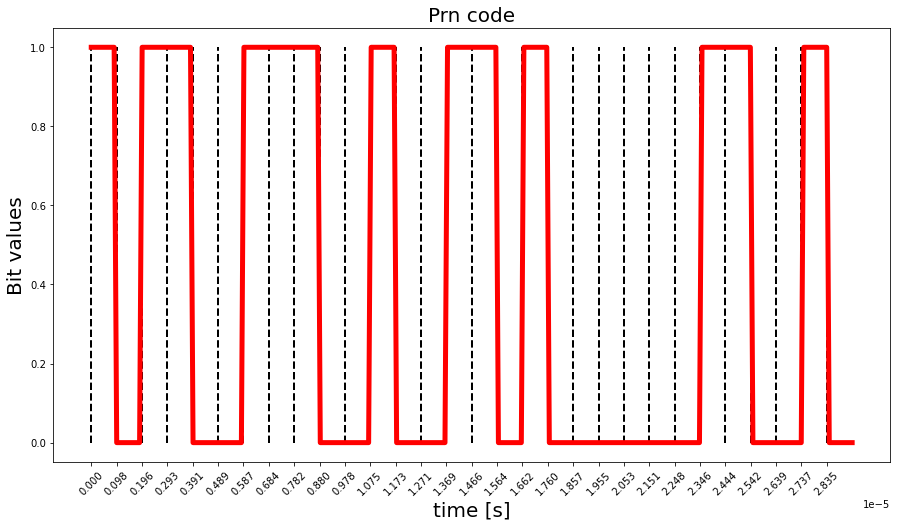

In [9]:
# function that plots a waveform corresponding to the first N chips of a certain prn code

def plot_prn(N, prn):
    
    Rc = 1.023e06   # chip rate
    Tc = 1 / Rc     # chip period 

    prn = prn[0:N]
    print("\nPrn to plot: ", prn, "\n")

    # In order to plot the code we need a certain number of samples equal to the bit to represent. This is
    # because, in order to obtain a waveform, we cannot just plot 1, then 0, then 1 etc. Instead, we need a certain
    # number of samples equal to 1 (in order to see a continuous line), then a certain number of samples equal 
    # to 0 etc.
    # The number that was chosen is 10 (there are no particular reasons for this)

    #time axis
    t = np.linspace(0, N*Tc , 10*N)
    m = np.zeros(10*N)
    ticks = np.arange(0, N*Tc, Tc)

    # In order to plot the code we need a certain number of samples equal to the bit to represent. This is
    # because, in order to obtain a waveform, we cannot just plot 1, then 0, then 1 etc. Instead, we need a certain
    # number of samples equal to 1 (in order to see a continuous line), then a certain number of samples equal 
    # to 0 etc.
    # The number that was chosen is 10 (there are no particular reasons for this)

    c = 0
    for i in range(len(m)):
        if i != 0 and i%10 == 0:
            c = c + 1
        m[i] = prn[c]

    fig = plt.figure(figsize=(15,8))
    plt.xticks(rotation=45)
    ax = fig.add_subplot(1,1,1)
    ax.plot(t, m, color='red', lw=5)
    ax.set_xticks(ticks)
    plt.xticks(rotation=45)
    ax.set_xlabel("time [s]", fontsize=20)
    ax.set_ylabel("Bit values", fontsize=20)
    ax.set_title("Prn code", fontsize=20)
    
    #plotting some dashed vertical lines in correspondance of consecutive chip periods (not mandatory)
    for i in ticks:
        ax.vlines(i, 0, 1, color='black', ls='dashed', lw=2)

    print("Chip period Tc: ", Tc, "\n")
    
    
# if we want to plot the first 30 chips of the first code in the e1c dataframe we need to write:
plot_prn(30, e1c['Binary'][0])